# AutoEncoder

* Compress and Decompress structure
* Bottleneck for information compression
* Other similiar structure: VAE, UNet, Hourglass Network

Reference: DS-GA 1008

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [ ]:
# Convert vector to image

def to_img(x):
#     x = (x-x.min())/(x.max()-x.min())
    return x.permute(0,2,3,1)

In [ ]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [ ]:
# Define data loading step

batch_size = 256

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = torchvision.datasets.CIFAR10('../data', train=True, download=True,
                                             transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(32 * 32 *3, d),
#             nn.Tanh(),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(d, 32 * 32 * 3),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [ ]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0089
epoch [2/20], loss:0.0065
epoch [3/20], loss:0.0053
epoch [4/20], loss:0.0048
epoch [5/20], loss:0.0047
epoch [6/20], loss:0.0044
epoch [7/20], loss:0.0042
epoch [8/20], loss:0.0044
epoch [9/20], loss:0.0039
epoch [10/20], loss:0.0037
epoch [11/20], loss:0.0037
epoch [12/20], loss:0.0038
epoch [13/20], loss:0.0036
epoch [14/20], loss:0.0036
epoch [15/20], loss:0.0032
epoch [16/20], loss:0.0035
epoch [17/20], loss:0.0030
epoch [18/20], loss:0.0033
epoch [19/20], loss:0.0029
epoch [20/20], loss:0.0034


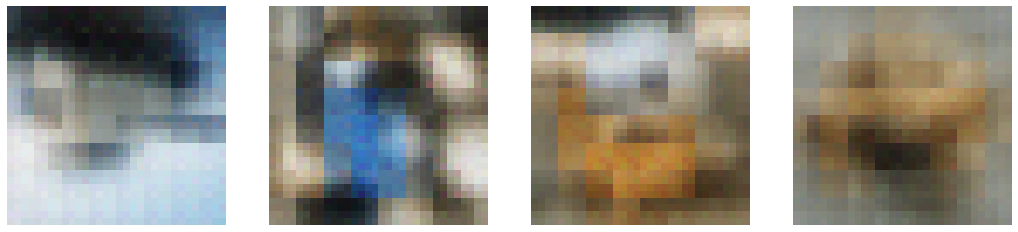

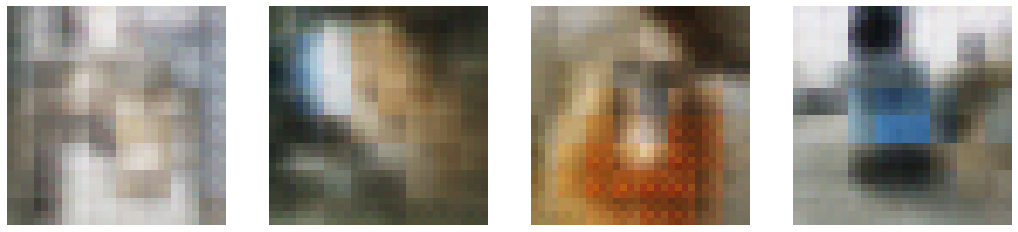

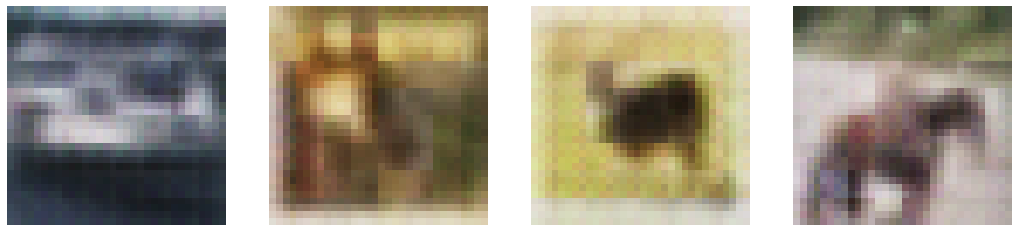

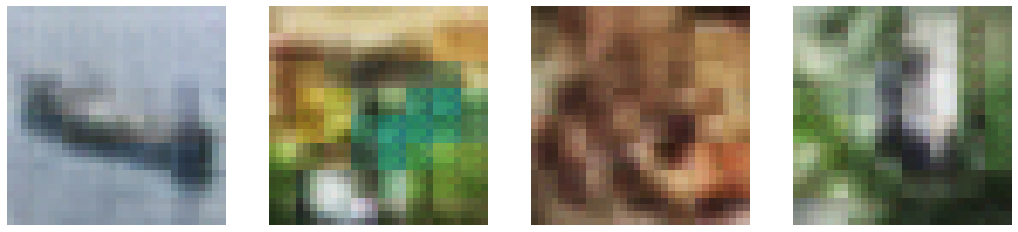

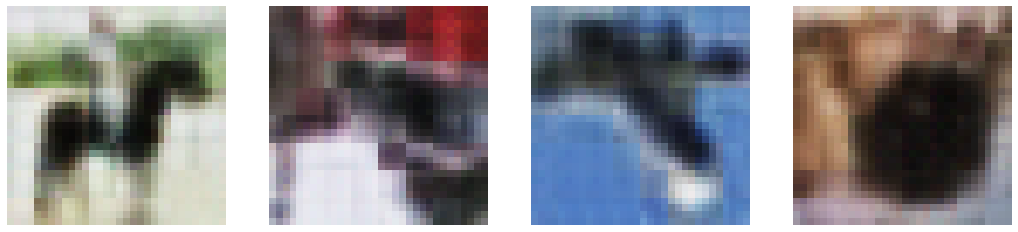

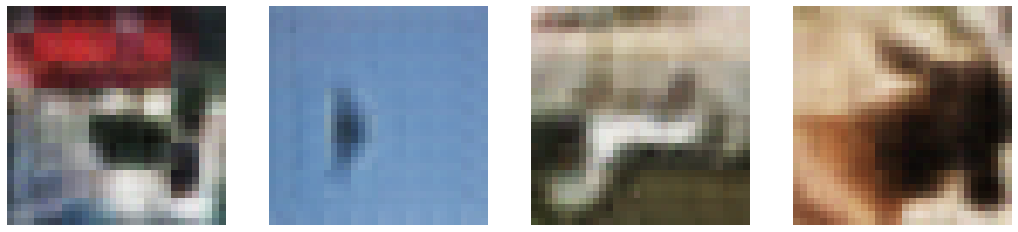

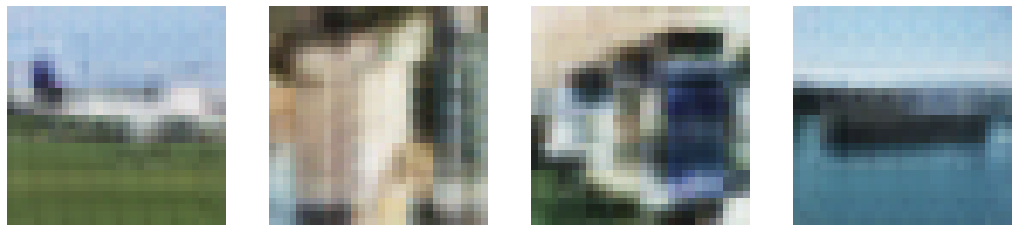

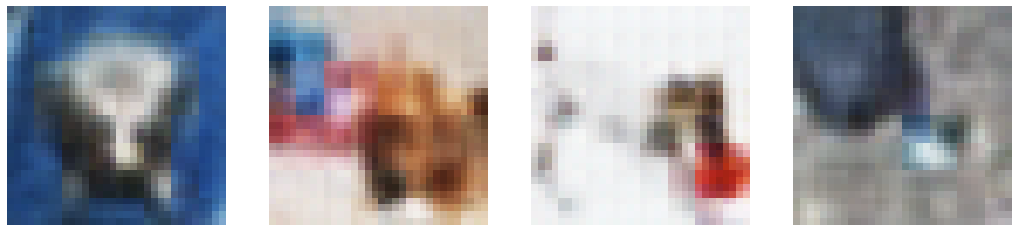

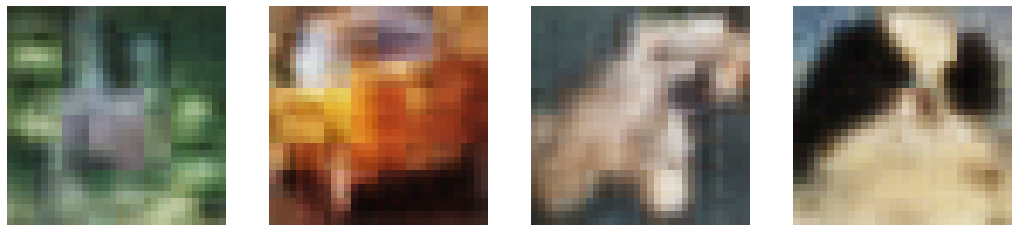

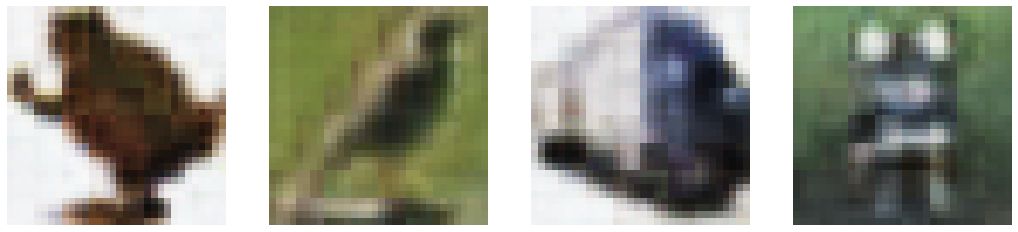

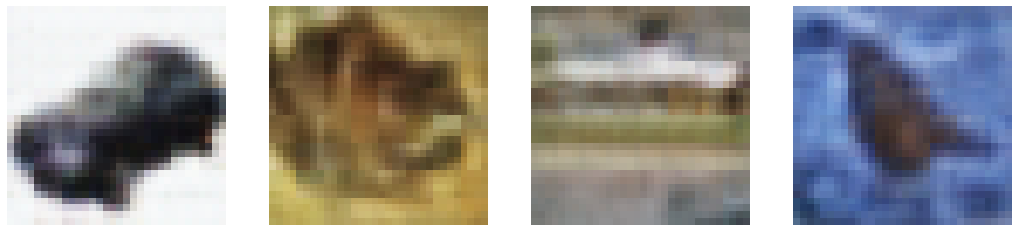

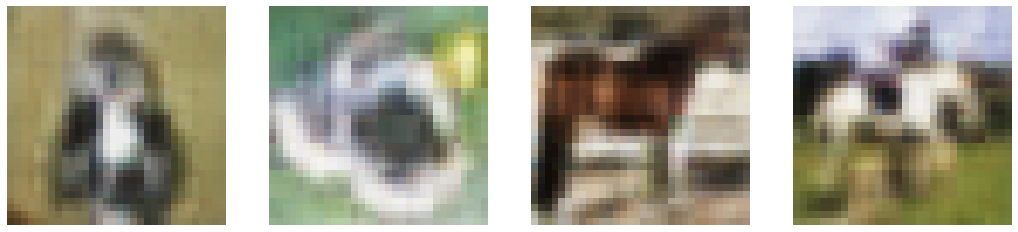

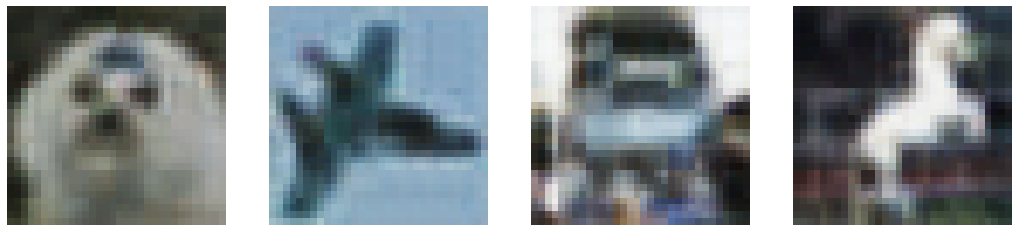

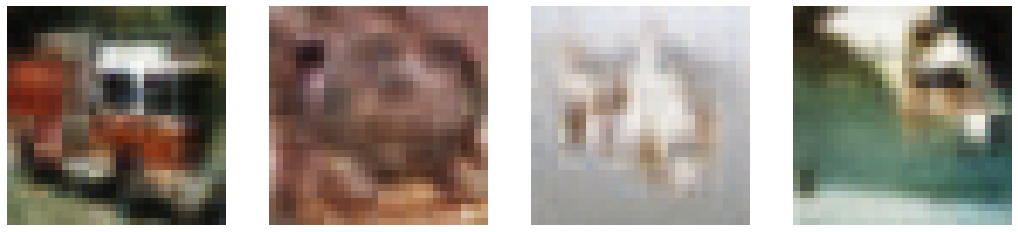

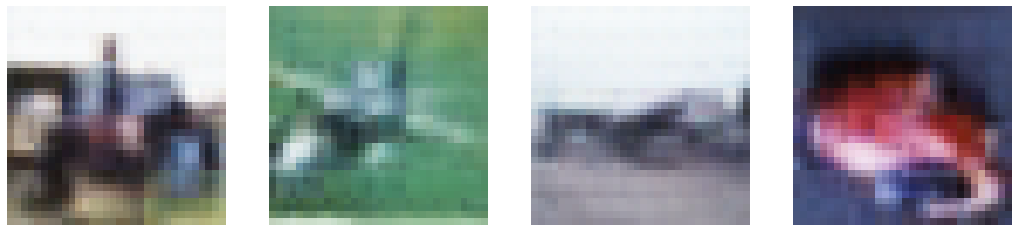

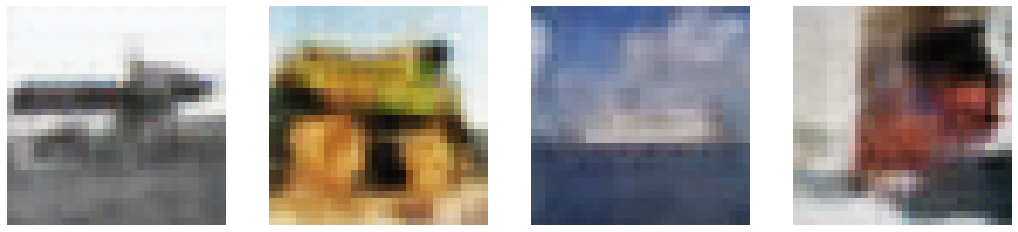

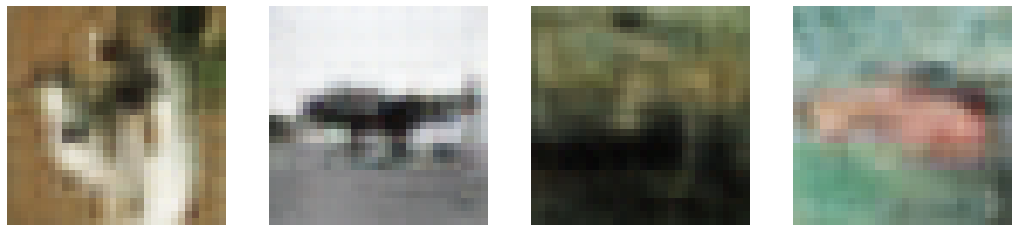

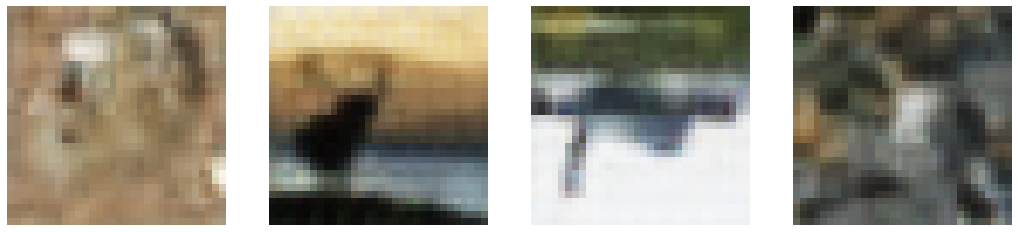

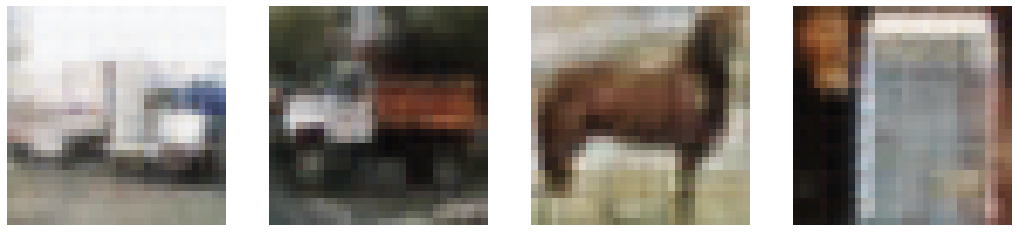

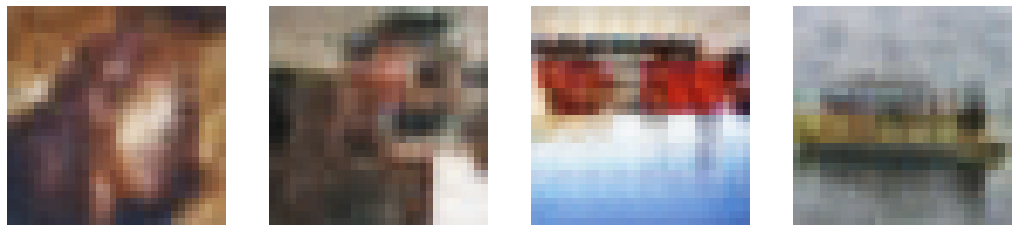

In [ ]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        output = model(img)  
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

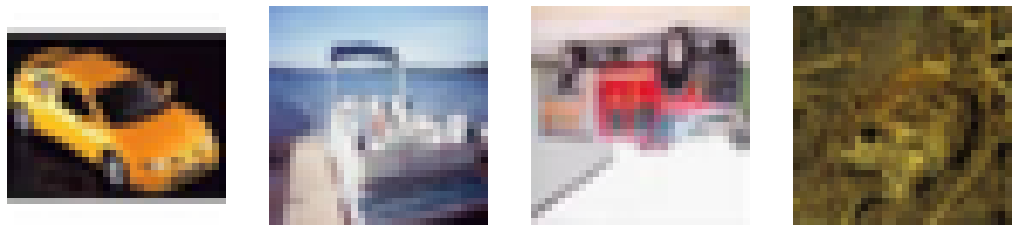

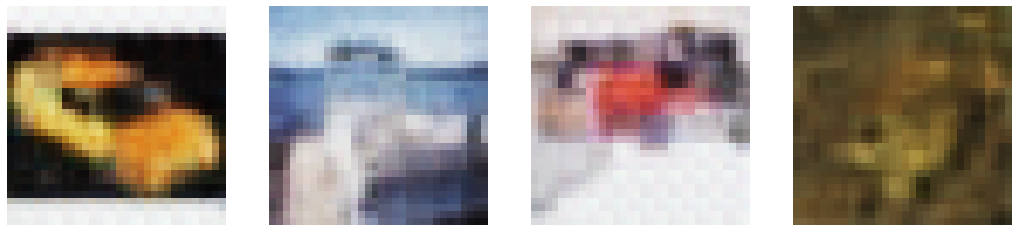

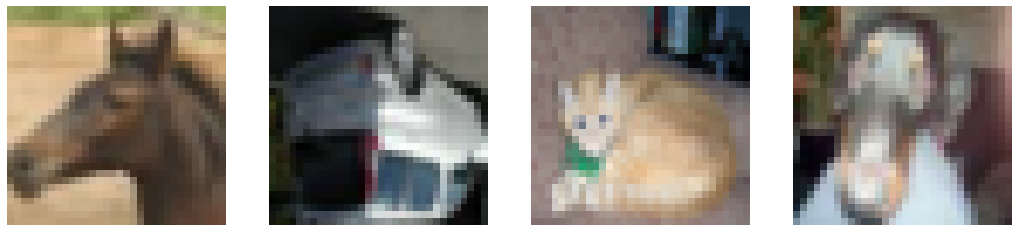

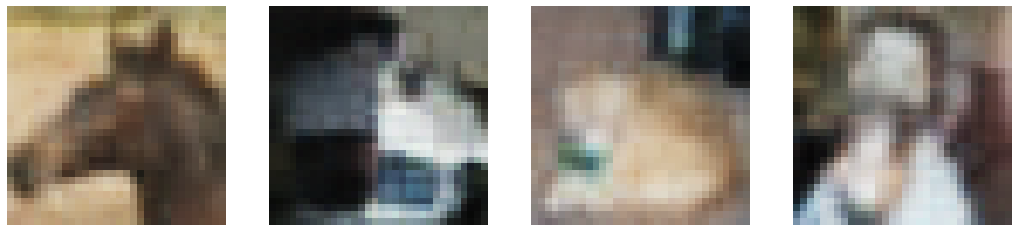

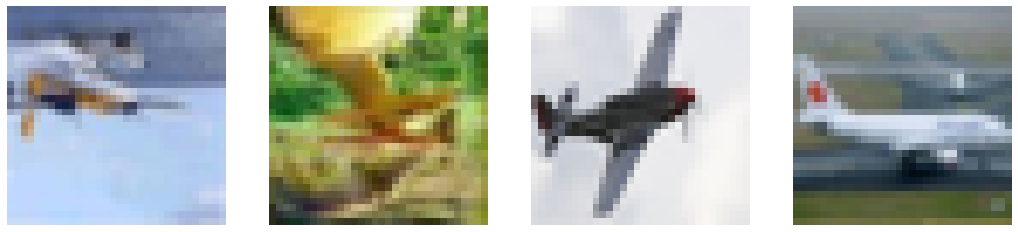

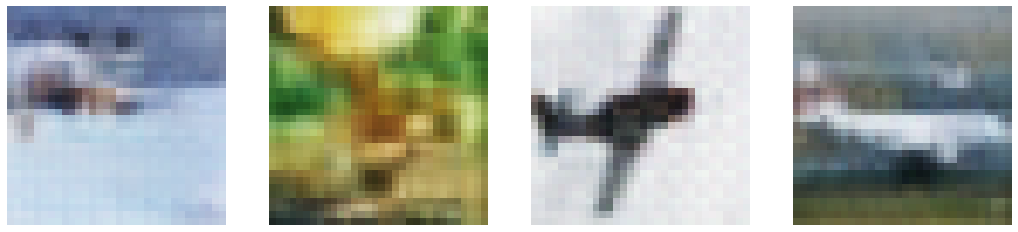

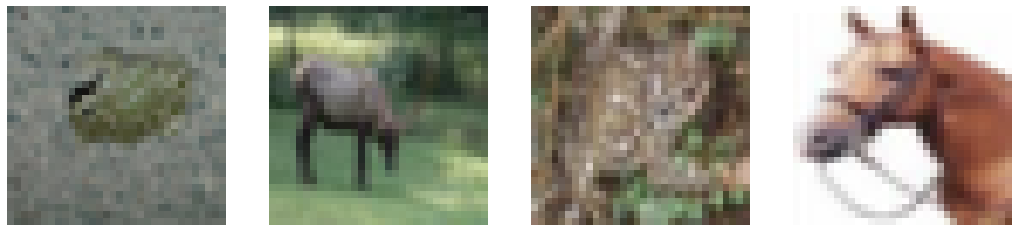

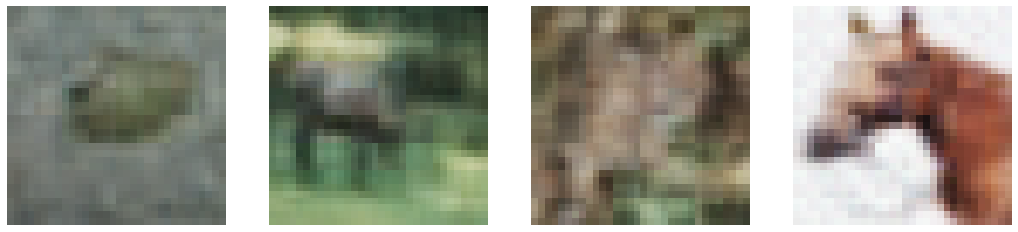

In [ ]:
display_images(img, output, 4)